In [1]:
%matplotlib notebook

Code to recreate Figure 1BD

In [4]:
from pathlib import Path 
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import imageio

# Statistics:
from scipy import stats
import statsmodels.api as sm
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=18)

import statsmodels.api as sm

# Import shared_functions
import sys
import os
sys.path.insert(0, str(Path(os.getcwd()).parent))
import shared_functions

In [5]:
black_background = False # black background for slides
if black_background:
    plt.style.use('dark_background') 

In [17]:
savepath = Path('G:\\My Drive\\PhD\\Papers\\Vanishing spikes\\plots\Fig1\\banana')
root_path = Path('G:\\My Drive\\PhD\\Papers\\Vanishing spikes\\all_data\\Behavior\\banana')

In [7]:
def collect_data(datapath):
    no_of_folders=0
    for folder in datapath.iterdir():
        if folder.is_dir():
            no_of_folders +=1

    max_coordinates = np.zeros((2,no_of_folders))

    counter = 0
    for current_folder in datapath.iterdir():
        if current_folder.is_dir():
            files_of_interest = []
            for current_file in current_folder.iterdir():
            # Since there's the suboptimal naming convention when
            # collecting a video of 'data.csv' to denote info about the
            # stimulus and when then doing analysis it's also called
            # 'data.csv' the loop below first collects all data.csv names
            # and selects the newest one (as analysis must have been done
            # after the data collection)
                if 'data.csv' in current_file.name:
                    files_of_interest.append(current_file)
                    #data_name = i
            if len(files_of_interest) == 1:
                data_name = files_of_interest[0]
            else:
                files_of_interest.sort()
                data_name = files_of_interest[-1]
                #print(data_name)

            data_csv = pd.read_csv(data_name)
            # PiVR currently has some suboptimal behavior where zeros (0) are 
            # used to indicate where tracking has failed. 
            # To make sure no unexpected data is produced, I'll change them here to nan
            zero_indeces = np.where(data_csv['X-Centroid'] == 0)[0]
            for current_column in data_csv.columns:
                if not current_column == 'Frame':
                    #print(current_column)
                    # Remember: Better to use loc compared to chained indexing!
                    # https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
                    #data_csv[current_column][zero_indeces] = np.nan
                    data_csv.loc[zero_indeces, current_column] = np.nan

            # Will throw error if not already analyzed! Run PiVR DST before running this script!
            dst = pd.read_csv(Path(current_folder, 'distance_to_source.csv'), sep=',')

            if counter == 0:
                all_dst = np.zeros((dst.shape[0], no_of_folders))

            with open((Path(current_folder, 'experiment_settings.json')), 'r') as file:
                experiment_settings = json.load(file)
                fps = experiment_settings['Framerate']
                pixel_per_mm = experiment_settings['Pixel per mm']
                max_coordinates[:,counter] = experiment_settings['Source y'], experiment_settings['Source x']

            if counter ==0:
                all_pixel_per_mm= np.zeros(no_of_folders)
            all_pixel_per_mm[counter] = pixel_per_mm

            y = np.asarray(data_csv['Y-Centroid'])
            x = np.asarray(data_csv['X-Centroid'])
            if counter == 0:
                centroid_coordinates = np.zeros((x.shape[0],2,no_of_folders))

            if x.shape[0] < centroid_coordinates.shape[0]:
                centroid_coordinates[0:x.shape[0], 0, counter] = y
                centroid_coordinates[0:x.shape[0], 1, counter] = x

            elif x.shape[0] > centroid_coordinates.shape[0]:
                temp = centroid_coordinates.copy()

                centroid_coordinates = np.zeros((x.shape[0],2,no_of_folders)) 

                centroid_coordinates[0:temp.shape[0],:,:] =  temp

                centroid_coordinates[:, 0, counter] = y
                centroid_coordinates[:, 1, counter] = x    

            else: 
                centroid_coordinates[:, 0, counter] = y
                centroid_coordinates[:, 1, counter] = x  


            if dst.shape[0] < all_dst.shape[0]:
                all_dst[0:dst.shape[0],counter] = dst['0']

            elif dst.shape[0] > all_dst.shape[0]:

                temp_dst = all_dst.copy()
                all_dst = np.zeros((dst.shape[0], no_of_folders))
                all_dst[0:temp_dst.shape[0],:] = temp_dst
                all_dst[:,counter] = dst['0'] 
            else:
                all_dst[:,counter] = dst['0'] 

            counter += 1

    # Set all zeros to np.nan as zeros mean that animals was not tracked during that frame. 
    centroid_coordinates[centroid_coordinates == 0] = np.nan
    
    return(centroid_coordinates, max_coordinates, all_dst, pixel_per_mm)

In [9]:
def plot(centroids, center, savename, plotcolor, px_per_mm, colored_exp_number):
    image_res_x = 1024
    image_res_y = 768
    
    # To show the same in the plot as in the stats I need to adjust the duration of what I show
    # to fit with the stats.
    # Discuss with ML
    framerate = 15 # MUST BE CORRECT
    #take_time_start = 30 # seconds
    take_time_end = 240# end
    #take_time_start *= framerate
    take_time_end *= framerate
    
    fig,ax=plt.subplots()

    # center the maximum value and the corresponding x/y values
    for i in range(center.shape[1]):
        y_shift = (image_res_y/2-center[0,i])
        x_shift = (image_res_x/2-center[1,i])
        shifted_y = centroids[:,0,i] + y_shift
        shifted_x = centroids[:,1,i] + x_shift
               
        if black_background:
            ax.scatter(y=shifted_y,x=shifted_x, s=0.0001, c='w'
                   ) 
            
        else:
            if i == colored_exp_number:
                #ax.scatter(y=shifted_y,
                #           x=shifted_x, s=0.001, c='b'
                #           ) 
                ax.plot(shifted_x[0:take_time_end],
                        shifted_y[0:take_time_end],
                        c=plotcolor, alpha=1, lw=0.5)
                            #ax.scatter(y=shifted_y,
                #           x=shifted_x, s=0.001, c='b'
                #           ) 
            else:
                ax.plot(shifted_x[0:take_time_end],
                        shifted_y[0:take_time_end],
                        c='k', alpha=0.10, lw=0.5)

    diameter_of_cup = 14.29
    radius_of_cup = diameter_of_cup/2
    pixel_per_mm = 8 

    circle1 = plt.Circle((1024/2, 768/2), radius_of_cup * pixel_per_mm, color='gold', alpha = 1)
    ax.add_patch(circle1)
    ax.set_ylim(0,image_res_y)
    ax.set_xlim(0,image_res_x)
    #ax.set_title('n=' + repr(centroids.shape[2]))
    ax.axis('off')
    ax.invert_yaxis()
    
    scalebar = AnchoredSizeBar(ax.transData,
                   px_per_mm*10, '10 mm', 'lower center', 
                   pad=0.1,
                   color='k',
                   frameon=False,
                   size_vertical=0.01,
                   fontproperties=fontprops)

    ax.add_artist(scalebar)

    #fig.savefig(Path(savepath, savename)) # uncomment to plot

<IPython.core.display.Javascript object>


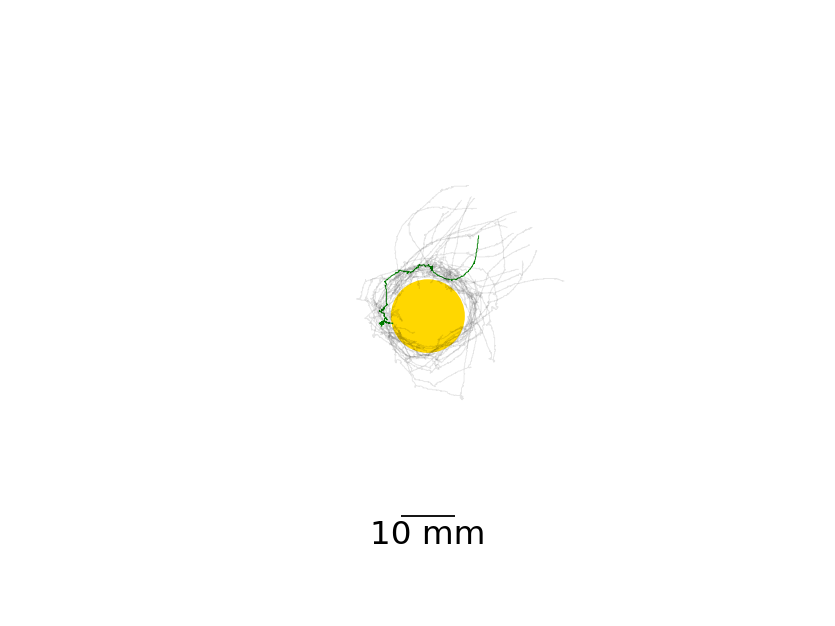

In [10]:
datapath = Path(root_path, 'w1118 pieces')

w1118_pieces_centroids, w1118_pieces_source, w1118_pieces_dst, px_per_mm = collect_data(datapath)
plot(w1118_pieces_centroids, w1118_pieces_source, 'Fig1B_w1118_pieces_NEW.svg', plotcolor='green', px_per_mm=px_per_mm, 
     colored_exp_number=4)

<IPython.core.display.Javascript object>


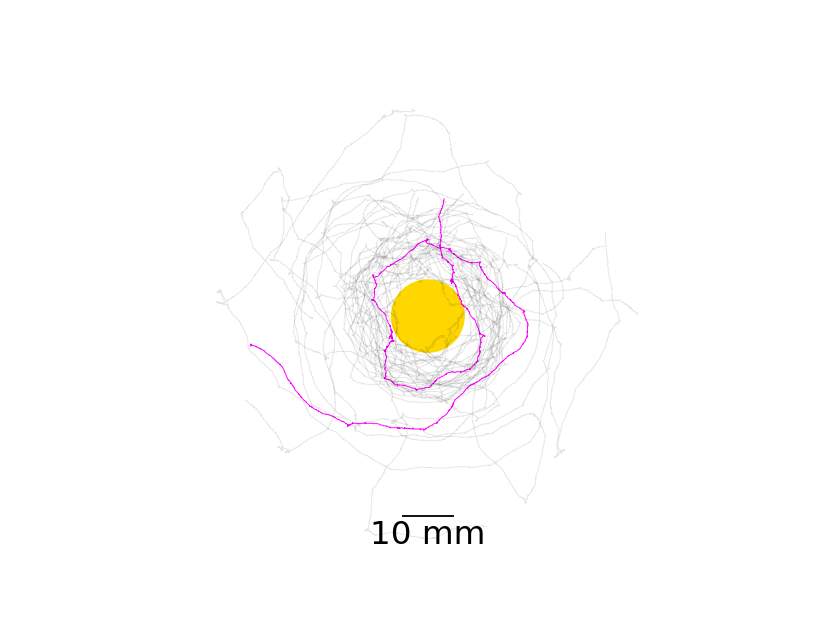

In [14]:
datapath = Path(root_path, 'MS92xMS133 pieces')

Or42bSF_pieces_centroids, Or42bSF_pieces_source, Or42bSF_pieces_dst, px_per_mm = collect_data(datapath)

plot(Or42bSF_pieces_centroids, Or42bSF_pieces_source, 'Fig1B_Or42bSF_pieces_NEW.svg', 
     plotcolor='magenta', px_per_mm=px_per_mm, colored_exp_number=3)

# Orco-/- pieces

<IPython.core.display.Javascript object>


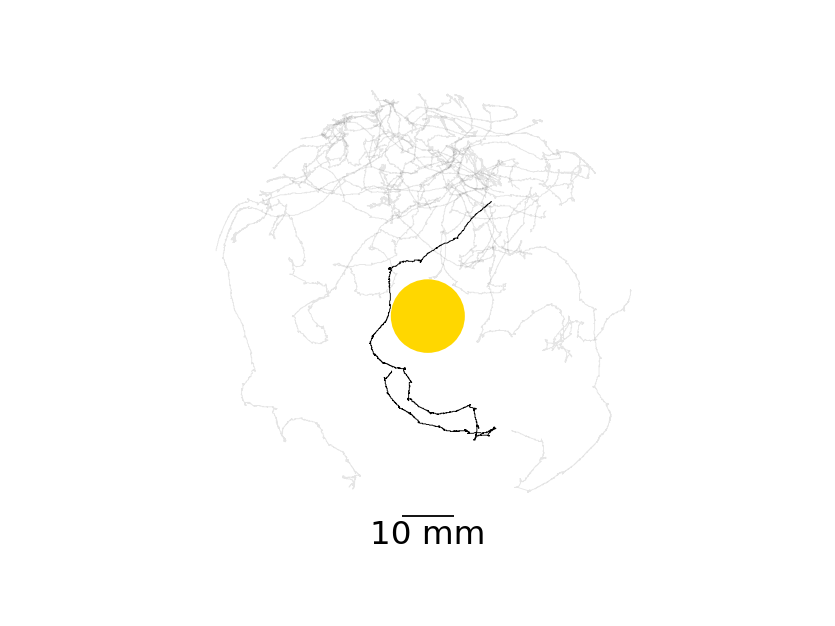

In [15]:
datapath = Path(root_path, 'FDT445xMS133 pieces')

orcoNull_pieces_centroids, orcoNull_pieces_source, orcoNull_pieces_dst, px_per_mm = collect_data(datapath)

plot(orcoNull_pieces_centroids, orcoNull_pieces_source, 'Fig1B_orcoNull_pieces_NEW.svg', 
     plotcolor='k', px_per_mm=px_per_mm, colored_exp_number=1)

# Plot boxplot

<IPython.core.display.Javascript object>


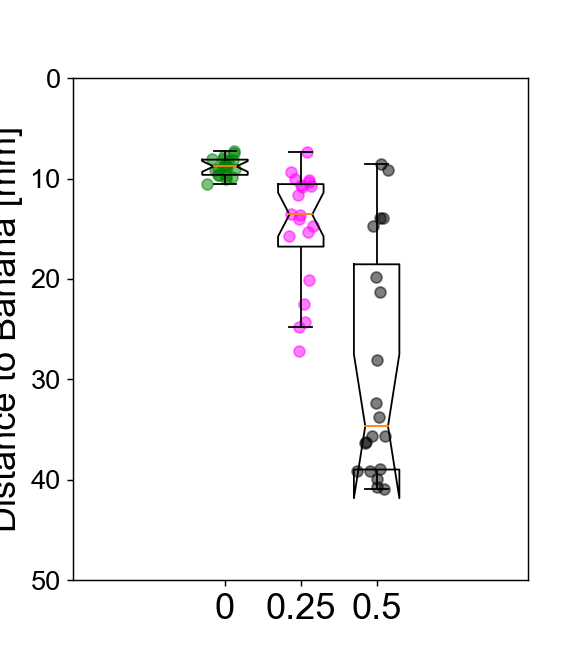

In [18]:
# I start by taking the distance to source for 30-60 seconds after the start of the experiment
framerate = 15 # MUST BE CORRECT
take_time_start = 30 # seconds
take_time_end = 60 # end

take_time_start *= framerate
take_time_end *= framerate

if black_background:
    colors = ['blue'
              'magenta',
              'k']
else:
    colors=['green',
           'magenta',
           'k']
    
def plot_data(data, box_counter = 0,boxplot_width = (0.15)):
    """
    Helper function to make sure both conditions are plotted identically
    """
    df_for_stats = pd.DataFrame()
    
    box_counter = box_counter
    for i in range(len(data)): 
        #print(label[i])
        data_to_plot = np.nanmean(data[i][take_time_start:take_time_end,:], axis=0)
        ax.boxplot(data_to_plot, positions=[box_counter],
                  notch=True, showfliers=False,
                       widths=boxplot_width)

        x_positions = np.random.normal(box_counter, 0.02, size=data[i].shape[1])
        ax.scatter(x=x_positions, y=data_to_plot, 
                       alpha=0.5, color=colors[i], label=label[i],zorder=0)

        box_counter += 0.25
        
        dict_for_stats = {
        'Group': [label[i]] * x_positions.shape[0],
        'median_DTS': data_to_plot
                    }

        df_to_add = pd.DataFrame(dict_for_stats)
        
        try:
            df_for_stats = pd.concat([df_to_add, df_for_stats],ignore_index=True)
            df_for_stats.reset_index()
        except Exception as e:
            print(e)
            df_for_stats = df_to_add
            

        
    return(df_for_stats)

   
#data_10per = [w1118_10per_dst,
#              Or42bSF_10per_dst,
#              orcoNull_10per_dst]
label = ['w1118',
          'Or42bSF',
          'Orco-/-']


#df_diluted = plot_data(data_10per, box_counter = 0)
# box_counter += 1

data_pieces = [w1118_pieces_dst,
               Or42bSF_pieces_dst,
               orcoNull_pieces_dst]


fig = plt.figure(figsize = (len(data_pieces)*1.5,5))
ax = fig.add_subplot(111)


df_pieces = plot_data(data_pieces)
    
#ax.set_xlim(-0.25, box_counter+0.75)
ax.set_ylabel('Distance to Banana [mm]', size=20)
#ax.tick_params(
#    axis='x',          # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off
#    top=False,         # ticks along the top edge are off
#    labelbottom=False) # labels along the bottom edge are off
ax.yaxis.set_tick_params(labelsize=15)
ax.set_ylim(0,50)
ax.invert_yaxis()
#fig.legend(fontsize=15)
fig.savefig(Path(savepath, 'Fig1C_banana_stats_DST_NEW.svg'))

In [19]:
"""
ANOVA Assumptions

1) Residuals (experimental error) are approximately normally distributed (Shapiro-Wilks test or histogram)
2) homoscedasticity or Homogeneity of variances (variances are equal between treatment groups) 
   (Levene’s or Bartlett’s Test)
3) Observations are sampled independently from each other (no relation in observations between the 
   groups and within the groups) i.e., each subject should have only one respon
"""
for i in range(len(data_pieces)): 
    print(label[i])
    print(sm.stats.lilliefors(np.nanmedian(data_pieces[i][take_time_start:take_time_end,:], axis=0)))

w1118
(0.15473245173433126, 0.23516320392014517)
Or42bSF
(0.2024203531010721, 0.03148434174230558)
Orco-/-
(0.2182326817286364, 0.014402768906943456)


In [20]:
"""
# CANT USE ANOVA AS DATA IS NOT NORMALLY DISTRIBUTED
# pure
lm = sfa.ols('median_DTS ~ C(Group)', data=df_for_stats_pieces).fit()
anova = sa.stats.anova_lm(lm)
print(anova)
print('\n')
print(sp.posthoc_ttest(df_for_stats_pieces, val_col='median_DTS', group_col='Group', p_adjust='holm'))
"""


# Prepare data as indicated here:
# https://pythonrepo.com/repo/maximtrp-scikit-posthocs-python-science-and-data-analysis
df_pieces.columns = df_pieces.columns.str.replace('.', '')
data_pieces = [df_pieces.loc[ids, 'median_DTS'].values for ids in df_pieces.groupby('Group').groups.values()]

print(stats.kruskal(*data_pieces))
print(sp.posthoc_conover(df_pieces, val_col='median_DTS', group_col='Group', p_adjust = 'holm'))

KruskalResult(statistic=36.39770491803279, pvalue=1.2483569977568633e-08)
              Or42bSF       Orco-/-         w1118
Or42bSF  1.000000e+00  3.427527e-04  8.613715e-07
Orco-/-  3.427527e-04  1.000000e+00  6.683927e-13
w1118    8.613715e-07  6.683927e-13  1.000000e+00


C:\Users\tadres\AppData\Local\Temp\ipykernel_24984\2982504097.py:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_pieces.columns = df_pieces.columns.str.replace('.', '')


# Export csv with stats

In [17]:
# Before calling export_statitics, make sure all names are properly renamed
labels = df_pieces.drop_duplicates(subset = ["Group"])['Group'] #extract unique group names
print(labels)

0     Orco-/-
20    Or42bSF
40      w1118
Name: Group, dtype: object


In [18]:
# Rename to be consistent with paper
df_pieces['Group'][df_pieces['Group'] == labels.iloc[2]] = 'wild type'

C:\Users\David\AppData\Local\Temp/ipykernel_19300/662952354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pieces['Group'][df_pieces['Group'] == labels.iloc[2]] = 'wild type'


In [20]:
labels = df_pieces.drop_duplicates(subset = ["Group"])['Group'] #extract unique group names
print(labels)

savepath_for_stats = Path('G:\\Shared drives\\LouisLab COLLABORATIVE Vanishing Spikes\\stats_files')

shared_functions.export_statistics_multiple(df_pieces,
                                            savepath=savepath_for_stats, 
                                            savename='Fig1c')

0       Orco-/-
20      Or42bSF
40    wild type
Name: Group, dtype: object
['Orco-/-', 'Or42bSF', 'wild type']
       Group   n       mean     median        STD       SEM  \
0    Orco-/-  20  28.906932  34.660815  11.276165  0.563808   
1    Or42bSF  20  14.845078  13.582027   5.659265  0.282963   
2  wild type  20   8.829314   8.795982   0.881083  0.044054   

                        95% CI on the mean statistical test  H statistic  \
0  (23.492426390560777, 34.32143802685398)   Kruskal-Wallis    36.397705   
1   (12.12765433399734, 17.56250239383661)             <NA>          NaN   
2   (8.406241625038241, 9.252385769906692)             <NA>          NaN   

        p value significant  effect size: eta^2  
0  1.248357e-08         YES            0.603469  
1           NaN         NaN                 NaN  
2           NaN         NaN                 NaN  


                Or42bSF       Orco-/-     wild type
Or42bSF    1.000000e+00  3.427527e-04  8.613715e-07
Orco-/-    3.427527e-04  